# System Identification

System identification is the process of finding a transfer function that predicts outputs
that are close to those predicted by experimental data. These data
may be obtained from actual experiments for from a detailed nonlinear model.
System identification involves: iteratively choosing the size of the numerator and denominator polynomial
of the transfer function,
estimating the parameters of the transfer function, and evaluating the quality of the fit to
the predictions of the transfer function.

## Preliminaries

In [42]:
!pip install -q controlSBML
!pip install -q control

In [43]:
import numpy as np
import controlSBML as ctl

import matplotlib.pyplot as plt
import control
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.2.3'

In [44]:
s = control.TransferFunction.s

## Models

### SEQUENTIAL_MODEL

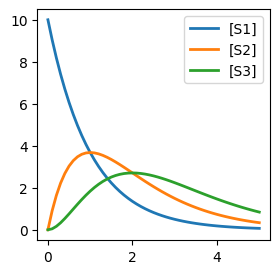

In [45]:
SEQUENTIAL_MODEL = """
model *model_main()
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 1
k3 = 1
end
"""
rr = te.loada(SEQUENTIAL_MODEL)
rr.simulate()
rr.plot(figsize=(3,3))

In [46]:
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, input_name="S1", output_name="S3")

### WOLF_MODEL

In [47]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
WOLF_MODEL = rr.getAntimony()
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_name="at_", output_name="s5")
print(WOLF_MODEL)

// Created by libAntimony v2.15.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

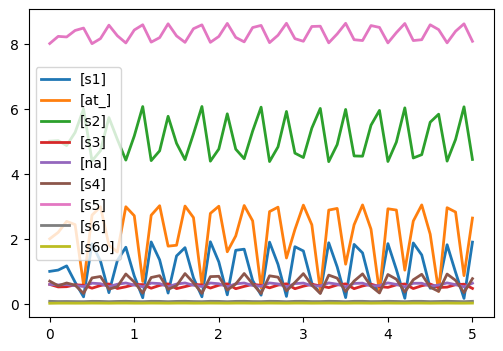

In [48]:
rr = te.loada(WOLF_MODEL)
rr.simulate()
rr.plot()

### MTOR_MODEL

In [49]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
rr = te.loadSBMLModel(MTOR_URL)
MTOR_MODEL = rr.getAntimony()
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_name="DEPTOR", output_name="mTORC1")
print(MTOR_MODEL)

// Created by libAntimony v2.15.0
model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in compartment_, pIR in compartment_, IRS in compartment_, pIRS in compartment_;
  species iIRS in compartment_, Akt in compartment_, pAkt in compartment_;
  species mTORC1 in compartment_, pmTORC1 in compartment_, mTORC2 in compartment_;
  species pmTORC2 in compartment_, imTORC2 in compartment_, mTORC1_DEPTOR in compartment_;
  species mTORC2_DEPTOR in compartment_, DEPTOR in compartment_, pDEPTOR in compartment_;

  // Reactions:
  v1: IR => pIR; compartment_*(V1*IR/(Km1 + IR));
  v2: pIR => IR; compartment_*(V2*pIR/(Km2 + pIR));
  v3: IRS => pIRS; compartment_*(k3c*IRS*pIR/(Km3 + IRS));
  v4: pIRS => IRS; compartment_*(V4*pIRS/(Km4 + pIRS));
  v5: Akt => pAkt; compartment_*(k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt));
  v6: pAkt => Akt

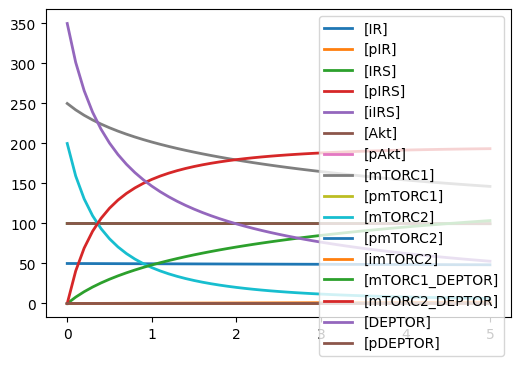

In [50]:
rr = te.loada(MTOR_MODEL)
rr.simulate()
rr.plot()

# Sequential model system identification

In this section, we use SEQUENTIAL_MODEL to illustrate system identification.
The work can be simplied by making use of the ``SISOTransferFunctionBuilder``
object in ``ControlSBML``.

## Step 1. Determine the operating region

The operating region is the range of control inputs that should handled by the controller.
We want to see how responsive the system is to the possible outputs from the controller.
We assess the operating region by using a *staircase input*.
This is a sequence of steps of the same height that have a duration that is sufficiently
long so that the system stabilizes.

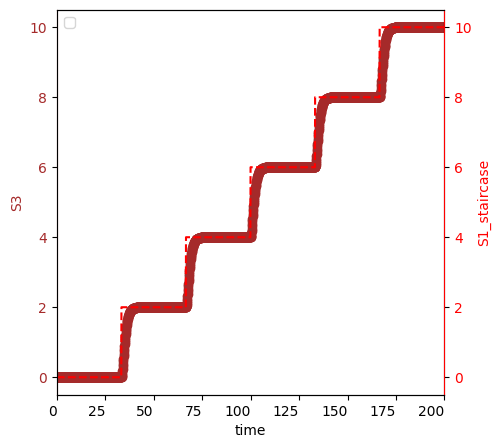

In [51]:
STAIRCASE = SEQUENTIAL_CTLSB.plotStaircaseResponse(times=np.linspace(0, 200, 2000))

## Step 2. Find the transfer function

To fit a transfer function, we must specify the number of terms in the
numerator and denominator polynomials for the transfer function.

In [65]:
?SEQUENTIAL_CTLSB.plotTransferFunctionFit

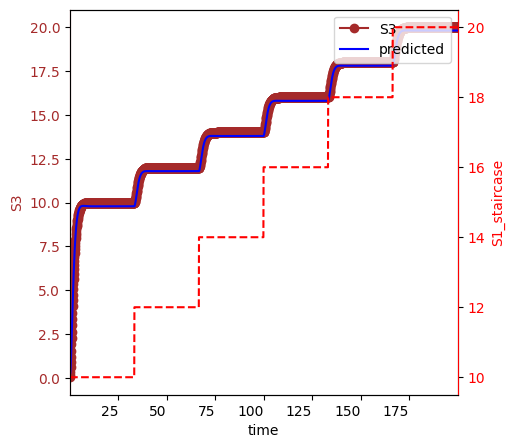

In [68]:
result = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=2,
            initial_value=10, final_value=20,
            times=np.linspace(0, 200, 2000))

In [69]:
SEQUENTIAL_TF = SEQUENTIAL_CTLSB.getOpenLoopTransferFunction()
print(SEQUENTIAL_TF)

<TransferFunction>: sys[187944]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


           0.5827
-----------------------------
0.5898 s^2 + 1.036 s + 0.5816



In [70]:
SEQUENTIAL_TF.poles()

array([-0.87826389+0.46341363j, -0.87826389-0.46341363j])

In [56]:
SEQUENTIAL_TF.dcgain()

np.float64(1.0015123770202368)

#  Wolf Transfer Function

In [57]:
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_name="s1", output_name="s5")

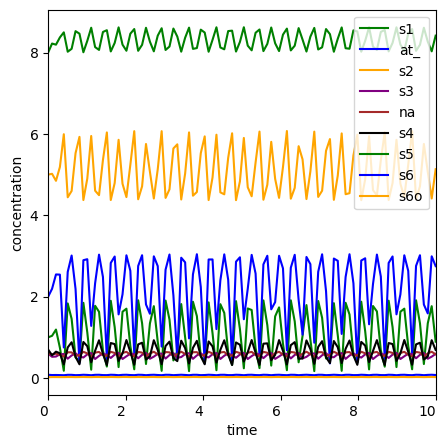

In [72]:
_ = WOLF_CTLSB.plotModel()

## Determine the operating region

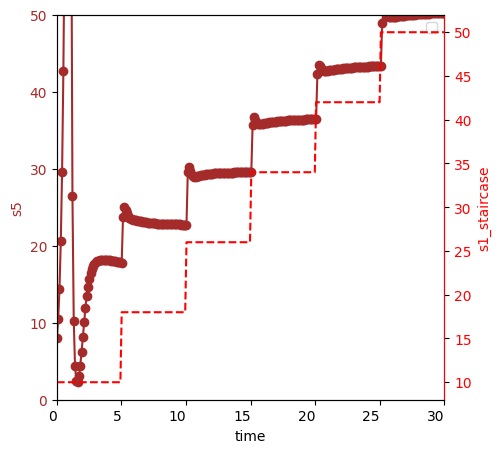

In [74]:
_ = WOLF_CTLSB.plotStaircaseResponse(times=np.linspace(0, 30, 300),
    initial_value=10, final_value=50, ylim=[0, 50])

## Find the transfer function

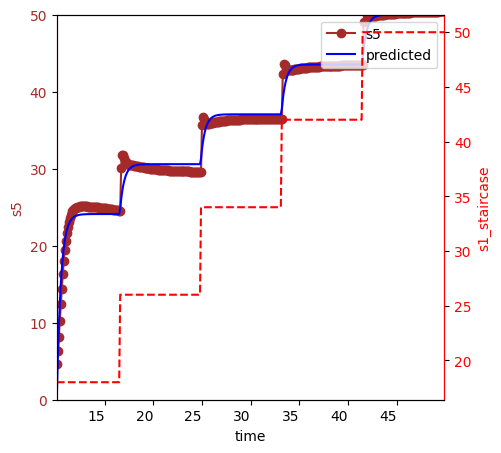

In [88]:
_ = WOLF_CTLSB.plotTransferFunctionFit(times=np.linspace(0, 50, 500),
            num_zero=1, num_pole=3,
            ylim=[0, 50],
            fit_start_time=10,
            initial_value=10, final_value=50)

The problem here is that the initial transient distorts the input/output relationship. We need to discard the early part to better fit the transfer function.

In [89]:
tf = WOLF_CTLSB.getOpenLoopTransferFunction()
print(tf)

<TransferFunction>: sys[235596]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            53.37 s + 0.0003654
--------------------------------------------
0.0003253 s^3 + 28 s^2 + 65.95 s + 0.0004584



In [84]:
tf.poles()

array([-0.09983468+0.95366324j, -0.09983468-0.95366324j])

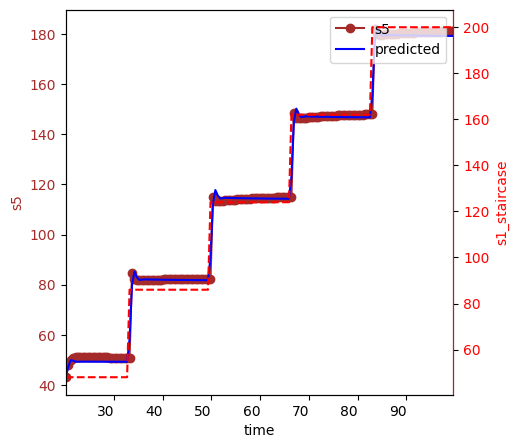

In [60]:
_ = WOLF_CTLSB.plotTransferFunctionFit(times=np.linspace(0, 100, 200), initial_value=10, final_value=200,
                                      fit_start_time=20)

In [61]:
WOLF_TF = WOLF_CTLSB.getOpenLoopTransferFunction()
print(WOLF_TF)

<TransferFunction>: sys[184144]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


             5.481e+04 s + 5692
---------------------------------------------
5695 s^3 + 2.282e+04 s^2 + 6.547e+04 s + 6667



In [62]:
WOLF_TF.poles()

array([-1.95108824+2.69767333j, -1.95108824-2.69767333j,
       -0.10562504+0.j        ])

In [63]:
WOLF_TF.dcgain()

np.float64(0.8537431732444738)

# Exercise: mTOR transfer function

In [64]:
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_name="V1", output_name="pmTORC1")

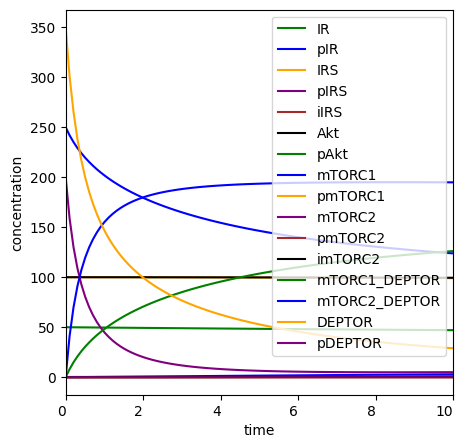

In [91]:
_ = MTOR_CTLSB.plotModel()

# Determine the operating region

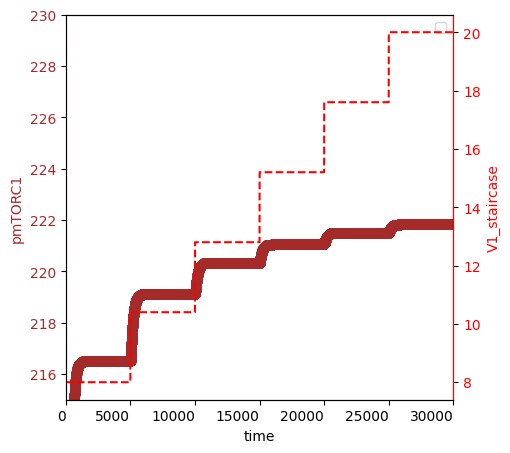

In [103]:
_ = MTOR_CTLSB.plotStaircaseResponse(times=np.linspace(0, 30000, 300000),
    initial_value=8, final_value=20, ylim=[215, 230])

In [ ]:
CTLSB.plotStaircaseResponse(times=np.linspace(0, 30000, 300000),
    initial_value=8, final_value=20, ylim=[215, 230])

# Find the transfer function

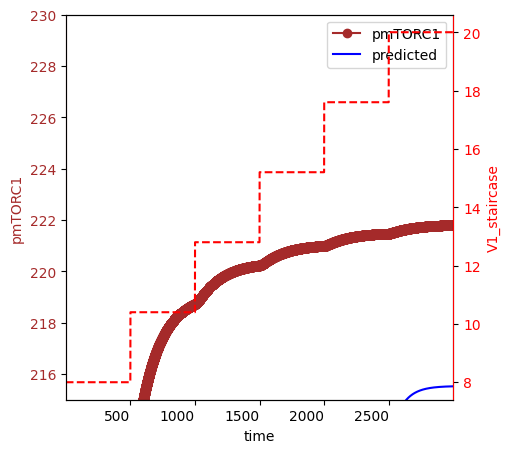

In [109]:
_ = MTOR_CTLSB.plotTransferFunctionFit(times=np.linspace(0, 3000, 30000),
        num_zero=0, num_pole=2,
        initial_value=8, final_value=20, ylim=[215, 230])